In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np

# Path to the main folder containing all ultrasound images
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'

# Define a function to load images from subfolders
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'dcm')):  # Adjust extensions as needed
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalize
                images.append(img_array)
    return np.array(images)

# Load all images from Google Drive
images = load_images_from_folder(base_dir)
print("Total images loaded:", images.shape)


Total images loaded: (0,)


In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the base directory (path to the images folder in Google Drive)
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'

# Step 3: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Step 4: Set up ImageDataGenerator to read images from the directory and subdirectories
data_gen = ImageDataGenerator(rescale=1./255)

# Define a generator to load images from all subfolders
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # No labels provided
    shuffle=True
)

# Step 5: Display a few sample images to confirm the setup
def show_sample_images(generator, num_samples=5):
    images = next(generator)  # Get a batch of images
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Call the function to show sample images
show_sample_images(train_generator)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

Found 126 images belonging to 3 classes.


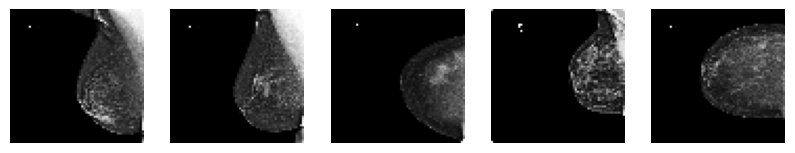

In [5]:
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
# Get the list of subdirectories
subfolders = [f.path for f in os.scandir(base_dir) if f.is_dir()]
# Limit to the first three subfolders
limited_dirs = subfolders[:3]

# Step 3: Create a temporary directory with symlinks to limit data generator to the first three folders
import tempfile
import shutil

# Create a temporary directory
temp_dir = tempfile.mkdtemp()

# Create symlinks in the temp directory to the limited subfolders
for subfolder in limited_dirs:
    # Get the subfolder name to use as the link name
    link_name = os.path.basename(subfolder)
    os.symlink(subfolder, os.path.join(temp_dir, link_name))

# Step 4: Set up the data generator to read images from the temporary directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

data_gen = ImageDataGenerator(rescale=1./255)

train_generator = data_gen.flow_from_directory(
    temp_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # No labels provided
    shuffle=True
)

# Step 5: Display a few sample images to confirm the setup
def show_sample_images(generator, num_samples=5):
    images = next(generator)  # Get a batch of images
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Call the function to show sample images
show_sample_images(train_generator)

# Clean up the temporary directory after loading the images
shutil.rmtree(temp_dir)

Found 126 images belonging to 3 classes.


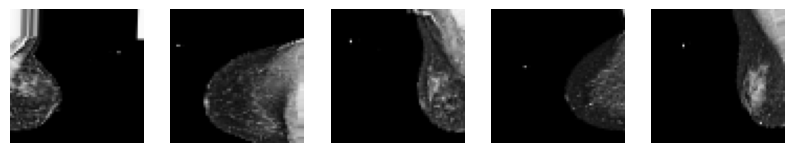

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


ValueError: None values not supported.

In [8]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tempfile
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Define base directory and limit to first three subfolders
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
subfolders = [f.path for f in os.scandir(base_dir) if f.is_dir()]
limited_dirs = subfolders[:3]

# Step 2: Create a temporary directory with symlinks to the limited subfolders
temp_dir = tempfile.mkdtemp()
for subfolder in limited_dirs:
    link_name = os.path.basename(subfolder)
    os.symlink(subfolder, os.path.join(temp_dir, link_name))

# Step 3: Set up data generator to read images from the temporary directory
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = data_gen.flow_from_directory(
    temp_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # No labels provided
    shuffle=True
)

# Step 4: Display a few sample images to confirm the setup
def show_sample_images(generator, num_samples=5):
    images = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, images.shape[0])):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Show sample images to confirm everything is working
show_sample_images(train_generator)

# Step 5: Define the CNN model using transfer learning
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the base model layers

cnn = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Set up callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)

# Step 7: Train the CNN model
cnn.fit(
    x=train_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Step 8: Make a prediction with a sample image from the dataset
sample_image_path = os.path.join(temp_dir, os.listdir(temp_dir)[0], os.listdir(os.path.join(temp_dir, os.listdir(temp_dir)[0]))[0])
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(64, 64))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
result = cnn.predict(img_array)
print("Prediction output:", result)

# Step 9: Clean up the temporary directory after loading the images
shutil.rmtree(temp_dir)


In [10]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import Libraries
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Step 3: Define the Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, batch_size=32, image_size=(64, 64)):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
        return np.array(images), np.zeros(len(batch_paths))  # Return images and dummy labels

# Step 4: Define Base Directory and Get Image Paths
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
image_paths = []

# Collecting image file paths from the specified directory
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for img_file in os.listdir(subfolder_path):
            img_file_path = os.path.join(subfolder_path, img_file)
            if img_file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Only include image files
                image_paths.append(img_file_path)

# Step 5: Create an Instance of the Custom Data Generator
train_generator = CustomDataGenerator(image_paths, batch_size=32, image_size=(64, 64))

# Step 6: Define the CNN Model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),  # Use Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Change to units=number_of_classes for multi-class
])

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Set up Callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)

# Step 8: Train the Model
cnn.fit(
    x=train_generator,
    epochs=10,  # Set a smaller number of epochs for testing
    callbacks=[early_stopping, reduce_lr]
)

# Step 9: Clean Up
# No need for clean up since we're using a generator with paths directly

print("Model training complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: Must provide at least one structure

In [11]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import Libraries
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Step 3: Define the Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, batch_size=32, image_size=(64, 64)):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
        # Create dummy labels
        return np.array(images), np.zeros(len(images))  # Return images and dummy labels

# Step 4: Define Base Directory and Get Image Paths
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
image_paths = []

# Collecting image file paths from the specified directory
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for img_file in os.listdir(subfolder_path):
            img_file_path = os.path.join(subfolder_path, img_file)
            if img_file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Only include image files
                image_paths.append(img_file_path)

# Step 5: Create an Instance of the Custom Data Generator
train_generator = CustomDataGenerator(image_paths, batch_size=32, image_size=(64, 64))

# Check if the generator outputs the correct structure
images, labels = train_generator[0]  # Get the first batch
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

# Step 6: Define the CNN Model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),  # Use Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Change to units=number_of_classes for multi-class
])

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Set up Callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)

# Step 8: Train the Model
cnn.fit(
    x=train_generator,
    epochs=10,  # Set a smaller number of epochs for testing
    callbacks=[early_stopping, reduce_lr]
)

print("Model training complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Batch shape: (0,)
Labels shape: (0,)


ValueError: Must provide at least one structure

In [12]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import Libraries
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Step 3: Define the Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, batch_size=32, image_size=(64, 64)):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
        return np.array(images), np.zeros(len(images))  # Return images and dummy labels

# Step 4: Define Base Directory and Get Image Paths
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
image_paths = []

# Collecting image file paths from the specified directory
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for img_file in os.listdir(subfolder_path):
            img_file_path = os.path.join(subfolder_path, img_file)
            if img_file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Only include image files
                image_paths.append(img_file_path)

# Check how many images were collected
print("Total images collected:", len(image_paths))

# Step 5: Create an Instance of the Custom Data Generator
if len(image_paths) > 0:
    train_generator = CustomDataGenerator(image_paths, batch_size=32, image_size=(64, 64))

    # Check if the generator outputs the correct structure
    images, labels = train_generator[0]  # Get the first batch
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

    # Step 6: Define the CNN Model
    cnn = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),  # Use Input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')  # Change to units=number_of_classes for multi-class
    ])

    # Compile the model
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Step 7: Set up Callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)

    # Step 8: Train the Model
    cnn.fit(
        x=train_generator,
        epochs=10,  # Set a smaller number of epochs for testing
        callbacks=[early_stopping, reduce_lr]
    )

    print("Model training complete.")
else:
    print("No images found in the specified directory.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images collected: 0
No images found in the specified directory.


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import Libraries
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Step 3: Define the Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, batch_size=32, image_size=(64, 64)):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
        return np.array(images), np.zeros(len(images))  # Return images and dummy labels

# Step 4: Define Base Directory and Get Image Paths
base_dir = '/content/drive/MyDrive/dicom_images_converted/acibademsana'
image_paths = []

# Collecting image file paths from the specified directory and its subfolders
for root, dirs, files in os.walk(base_dir):  # Use os.walk to traverse subdirectories
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Only include image files
            img_file_path = os.path.join(root, file)
            image_paths.append(img_file_path)

# Check how many images were collected
print("Total images collected:", len(image_paths))

# Step 5: Create an Instance of the Custom Data Generator
if len(image_paths) > 0:
    train_generator = CustomDataGenerator(image_paths, batch_size=32, image_size=(64, 64))

    # Check if the generator outputs the correct structure
    images, labels = train_generator[0]  # Get the first batch
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

    # Step 6: Define the CNN Model
    cnn = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),  # Use Input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')  # Change to units=number_of_classes for multi-class
    ])

    # Compile the model
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Step 7: Set up Callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3)

    # Step 8: Train the Model
    cnn.fit(
        x=train_generator,
        epochs=10,  # Set a smaller number of epochs for testing
        callbacks=[early_stopping, reduce_lr]
    )

    print("Model training complete.")
else:
    print("No images found in the specified directory.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images collected: 7345
Batch shape: (32, 64, 64, 3)
Labels shape: (32,)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 3071s 13s/step - accuracy: 0.9821 - loss: 0.0256 - learning_rate: 0.0010
Epoch 2/10
117/230 ━━━━━━━━━━━━━━━━━━━━ 5:24 3s/step - accuracy: 1.0000 - loss: 5.1761e-15